# Using Survey Data as a Predictor of Pandemic Vaccination
## 4 - NLP with LDA (soft clustering)

### Mark Patterson, March 2021 


### Introduction to 4: NLP Notebook
The purpose of this phase of my Capstone was to identify current topics of misinformation (within current social media) in order to better target information and education campaigns. 

Twint was used to "scrape" Twitter for tweets from the past year (Feb. 2020 to feb. 2021). I started with negative search terms (covid death; vaccine choice; etc.) as I wanted to find tweets that contained negative and misinformation that might prevent people from gettign vaccinated. The TextBlob library was used to assign sentiment to each tweet, words, bi-grams, and tri-grams were examined, and then LDA (soft clustering) was used to look for additional topic clusters. A small set of tweets was read for additional context and understanding.

Note that several iterations of this process occured with different subsets of the data. Eventually,the set of negative sentiment tweets were the focus of the analysis.

### Load appropriate libraries and data set(s)

In [1]:
# Import the relevant libraries and packages. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
from nltk.tokenize import word_tokenize, sent_tokenize 
nltk.download('punkt')
import string
from nltk import FreqDist

%matplotlib inline

# Increase column width to display df
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /Users/markp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/markp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Import the csv files and then need to stitch them together. 
dfB = pd.read_csv('data/vacchoice2.csv', sep='\t', lineterminator='\r')
print(dfB.shape)
dfB.head()

(1670, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,\n1363887309100376067,1.363885e+18,2021-02-22 08:24:08 PST,2021-02-22,08:24:08,-800.0,1.249665e+18,livingnothiding,Tom 🇪🇺🇬🇧🇹🇷🍪,NaN,@nadhimzahawi Can you still confirm that vacci...,en,[],[],['https://pbs.twimg.com/media/Eu2APN1WQAAiTwU....,2.0,1.0,7.0,[],[],https://twitter.com/LivingNotHiding/status/136...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2APN1WQAAiTwU.png,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'nadhimzahawi', 'name': 'Nadh...",NaN,NaN,NaN,NaN
1,\n1363871758399524868,1.363872e+18,2021-02-22 07:22:21 PST,2021-02-22,07:22:21,-800.0,1.059953e+18,guggsey,🔴,NaN,"If you’ve had your Covid vaccine, which did yo...",en,[],[],[],20.0,0.0,10.0,[],[],https://twitter.com/Guggsey/status/13638717583...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,\n1363849779378348035,1.363850e+18,2021-02-22 05:55:01 PST,2021-02-22,05:55:01,-800.0,2.610710e+07,kingofsunshine,Sohail Shah,NaN,Lost someone I loved dearly to COVID today. Pl...,en,[],[],[],6.0,1.0,14.0,['covid19'],[],https://twitter.com/KingOfSunshine/status/1363...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,\n1363819329435938816,1.363819e+18,2021-02-22 03:54:01 PST,2021-02-22,03:54:01,-800.0,9.153487e+17,fhussain73,Farzana Hussain,NaN,Let’s keep having the conversations. GPs &amp;...,en,[],[],[],2.0,4.0,31.0,[],[],https://twitter.com/fhussain73/status/13638193...,False,https://twitter.com/nhsconfed/status/136378266...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,\n1363809630682558464,1.363810e+18,2021-02-22 03:15:28 PST,2021-02-22,03:15:28,-800.0,4.089718e+08,rymmomtaz,Rym Momtaz ريم ممتاز,NaN,4 weeks after receiving 1 jab of AstraZeneca c...,en,[],[],[],1.0,1.0,5.0,[],[],https://twitter.com/RymMomtaz/status/136380963...,False,https://twitter.com/Birdyword/status/136379058...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [6]:
dfA = pd.read_csv('data/vacdeath2.csv', sep='\t', lineterminator='\r')
print(dfA.shape)
dfA.head()

(15001, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,\n1363895782475243527,1.363888e+18,2021-02-22 08:57:49 PST,2021-02-22,08:57:49,-800.0,2.753211e+09,mrsm_senta_ey,Ms M,NaN,@NEUnion It’s a death sentence for me. If mine...,en,[],[],[],3.0,2.0,12.0,[],[],https://twitter.com/MrsM_SENTA_EY/status/13638...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'NEUnion', 'name': 'National ...",NaN,NaN,NaN,NaN
1,\n1363895502627078147,1.363886e+18,2021-02-22 08:56:42 PST,2021-02-22,08:56:42,-800.0,1.331901e+18,lizw75477710,LizW,NaN,@BigBrotherWatch It will start off as just a v...,en,[],[],[],4.0,0.0,13.0,[],[],https://twitter.com/LizW75477710/status/136389...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BigBrotherWatch', 'name': 'B...",NaN,NaN,NaN,NaN
2,\n1363895430032031749,1.363895e+18,2021-02-22 08:56:25 PST,2021-02-22,08:56:25,-800.0,9.121231e+08,pickledpuffin,𝗠𝗮𝗿𝗶𝗼𝗻,NaN,Happy that the UK is doing well with their vac...,en,[],[],[],2.0,0.0,14.0,[],[],https://twitter.com/pickledpuffin/status/13638...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,\n1363889576583065600,1.363883e+18,2021-02-22 08:33:09 PST,2021-02-22,08:33:09,-800.0,9.245927e+17,apk_musicreview,Adam Knight,NaN,@UKCovid19Stats Remember folks this virus had ...,en,[],[],[],2.0,2.0,26.0,[],[],https://twitter.com/APK_musicreview/status/136...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'UKCovid19Stats', 'name': 'UK...",NaN,NaN,NaN,NaN
4,\n1363888280597647370,1.363887e+18,2021-02-22 08:28:00 PST,2021-02-22,08:28:00,-800.0,8.767923e+07,alexberenson,Alex Berenson,NaN,4/ So where are these new cases and deaths com...,en,[],[],[],3.0,18.0,83.0,[],[],https://twitter.com/AlexBerenson/status/136388...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [8]:
dfD = pd.read_csv('data/vacrefuse2.csv', sep='\t', lineterminator='\r')
print(dfD.shape)
dfD.head()

(6260, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,\n1363551422650802176,1.363551e+18,2021-02-21 10:09:27 PST,2021-02-21,10:09:27,-800.0,9.492108e+08,msgeekmedia,Ms. Geek says let's defeat COVID!!!,NaN,COVID-19 vaccination should be MANDATORY. Both...,en,[],[],[],1.0,2.0,5.0,[],[],https://twitter.com/msgeekmedia/status/1363551...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,\n1363471388049309700,1.363392e+18,2021-02-21 04:51:25 PST,2021-02-21,04:51:25,-800.0,1.120361e+18,david_j_bond,David_J_Bond,NaN,@MartinW11510691 @toryboypierce @BorisJohnson ...,en,[],[],[],0.0,3.0,10.0,[],[],https://twitter.com/David_J_Bond/status/136347...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MartinW11510691', 'name': 'M...",NaN,NaN,NaN,NaN
2,\n1363255097724198914,1.363178e+18,2021-02-20 14:31:58 PST,2021-02-20,14:31:58,-800.0,2.319922e+07,seandlynch,Seán D Lynch,NaN,@leoie @ciananbrennan 11 months failure to pro...,en,[],[],[],0.0,0.0,6.0,[],[],https://twitter.com/seandlynch/status/13632550...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'leoie', 'name': 'Leo O’Shaug...",NaN,NaN,NaN,NaN
3,\n1363182365510524928,1.363106e+18,2021-02-20 09:42:57 PST,2021-02-20,09:42:57,-800.0,1.765562e+07,aviatorwriting,“Heavy Mayday” Airline Pilot 🧑🏻‍✈️,NaN,"@Dugaru Airline pilots are, by and large, cons...",en,[],[],[],2.0,0.0,9.0,[],[],https://twitter.com/aviatorwriting/status/1363...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Dugaru', 'name': 'Doug Garro...",NaN,NaN,NaN,NaN
4,\n1362933877052895233,1.362934e+18,2021-02-19 17:15:33 PST,2021-02-19,17:15:33,-800.0,4.533734e+08,punt_rd,Punt Road,NaN,Australians banned from the PUB if they refuse...,en,[],['https://apple.news/AC1IymR2iTnO27Ua2Nr01_w'],[],0.0,1.0,8.0,['covid'],[],https://twitter.com/punt_rd/status/13629338770...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [10]:
dfC = pd.read_csv('data/vacfreedom.csv', sep='\t', lineterminator='\r')
print(dfC.shape)
dfC.head()

(7089, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,\n1363896935237697539,1.363897e+18,2021-02-22 09:02:23 PST,2021-02-22,09:02:23,-800.0,1.456987e+07,channel4news,Channel 4 News,NaN,"""A one-way road to freedom."" Boris Johnson se...",en,[],[],[],18.0,7.0,15.0,[],[],https://twitter.com/Channel4News/status/136389...,False,NaN,1.0,https://pbs.twimg.com/amplify_video_thumb/1363...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,\n1363895096664539145,1.363895e+18,2021-02-22 08:55:05 PST,2021-02-22,08:55:05,-800.0,1.337516e+18,frontinef,Frontline Freedom,NaN,I seriously wish anyone who chooses the vaccin...,en,[],[],[],1.0,1.0,38.0,[],[],https://twitter.com/FrontineF/status/136389509...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,\n1363894517020184580,1.363895e+18,2021-02-22 08:52:47 PST,2021-02-22,08:52:47,-800.0,7.938977e+17,johnoakes2020,John EFC #KBF,NaN,THAT ISN'T A ROAD MAP OUT THAT'S JUST PROLONGE...,en,[],[],[],3.0,10.0,19.0,[],[],https://twitter.com/johnoakes2020/status/13638...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,\n1363894454625665025,1.363894e+18,2021-02-22 08:52:32 PST,2021-02-22,08:52:32,-800.0,1.337516e+18,frontinef,Frontline Freedom,NaN,Shaking with temper. Quizzed on my vaccine sta...,en,[],[],[],11.0,3.0,53.0,[],[],https://twitter.com/FrontineF/status/136389445...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,\n1363890542799708161,1.363886e+18,2021-02-22 08:36:59 PST,2021-02-22,08:36:59,-800.0,1.314295e+18,britinbulgaria,Brit In Bulgaria,NaN,@bbcnickrobinson Most people are not going to ...,en,[],[],[],0.0,7.0,24.0,[],[],https://twitter.com/BritInBulgaria/status/1363...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'bbcnickrobinson', 'name': 'N...",NaN,NaN,NaN,NaN


In [11]:
dfE = pd.read_csv('data/vacside2.csv', sep='\t', lineterminator='\r')
print(dfE.shape)
dfE.head()

(11600, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,\n1363896341668184065,1.363896e+18,2021-02-22 09:00:02 PST,2021-02-22,09:00:02,-800.0,2.592825e+07,webmd,WebMD,NaN,Thinking of taking a painkiller before you get...,en,[],['https://wb.md/3s9DfuT'],['https://pbs.twimg.com/media/Eu2Ifo6XMAI-8-E....,0.0,9.0,13.0,[],[],https://twitter.com/WebMD/status/1363896341668...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2Ifo6XMAI-8-E.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,\n1363895923798024194,1.363896e+18,2021-02-22 08:58:22 PST,2021-02-22,08:58:22,-800.0,6.975819e+17,teamwolfmoon,Fact-Check Yourself Before You Wreck Yourself,NaN,After a week of being thwarted by truck issues...,en,[],[],['https://pbs.twimg.com/media/Eu2IE-CUcAA8Bwg....,1.0,0.0,24.0,"['musherlife', 'northwoodslife']",[],https://twitter.com/TeamWolfMoon/status/136389...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2IE-CUcAA8Bwg.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,\n1363887777910243333,1.363888e+18,2021-02-22 08:26:00 PST,2021-02-22,08:26:00,-800.0,2.349127e+08,lukeyism,Big Nas X,NaN,All the 60+ people who take the vaccine saying...,en,[],[],['https://pbs.twimg.com/media/Eu2AtIWXEAQsySa....,5.0,6.0,52.0,[],[],https://twitter.com/lukeyism/status/1363887777...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2AtIWXEAQsySa.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,\n1363873055039127552,1.363873e+18,2021-02-22 07:27:30 PST,2021-02-22,07:27:30,-800.0,7.510217e+17,gerdiebelt,Gerald,NaN,"One day, the future HIV+ peeps would wonder wh...",en,[],[],[],0.0,0.0,16.0,[],[],https://twitter.com/GerdieBelt/status/13638730...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,\n1363867677576466432,1.363868e+18,2021-02-22 07:06:08 PST,2021-02-22,07:06:08,-800.0,3.489067e+08,theromancechica,Sabrina Sol,NaN,My mom &amp; 94-year-old abuela get their seco...,en,[],[],[],5.0,1.0,38.0,[],[],https://twitter.com/theromancechica/status/136...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [16]:
# Combine the 5 df with concat. 
df_all = pd.concat([dfA, dfB, dfC, dfD, dfE], ignore_index=True)
print(df_all.shape)
df_all.tail()

(41620, 36)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
41615,\n906983137204477952,9.069831e+17,2017-09-10 13:50:05 PDT,2017-09-10,13:50:05,-800.0,1.252452e+07,mercola,Dr. Joseph Mercola,NaN,Fact: The U.S. military does NOT track any vac...,en,[],['http://ow.ly/WkFK30eYr9v'],[],7.0,50.0,42.0,[],[],https://twitter.com/mercola/status/90698313720...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
41616,\n905768906488414210,9.057689e+17,2017-09-07 05:25:10 PDT,2017-09-07,05:25:10,-800.0,1.252452e+07,mercola,Dr. Joseph Mercola,NaN,Fact: The U.S. military does NOT track any vac...,en,[],['http://ow.ly/3jfp30eOf90'],[],4.0,41.0,43.0,[],[],https://twitter.com/mercola/status/90576890648...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
41617,\n905043942441353216,9.050439e+17,2017-09-05 05:24:25 PDT,2017-09-05,05:24:25,-800.0,2.838925e+07,genekerrigan,Gene Kerrigan,NaN,"Dear FInian . . . FactCheck: No, the reported ...",en,[],['http://jrnl.ie/2970847'],[],5.0,11.0,23.0,[],[],https://twitter.com/GeneKerrigan/status/905043...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
41618,\n904878151272103937,9.048782e+17,2017-09-04 18:25:37 PDT,2017-09-04,18:25:37,-800.0,2.513103e+09,thesciencepost,The Science Post,NaN,CDC releases new list of vaccine side effects:...,en,"[{'screen_name': 'docmeehan', 'name': 'jim mee...",['http://thesciencepost.com/?p=70136'],[],0.0,7.0,17.0,"['vaccines', 'vaxxed']",[],https://twitter.com/thesciencepost/status/9048...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
41619,\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_cut = df_all

## Clean and Cut the DF down to useful size
The data frame will contain language = en only.
The data frame will contain tweets from 02-22-20 to 02-22-21 (a one year period).

In [19]:
df_cut.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [20]:
# Remove unneeded columns
df_cut1 = df_cut.drop(columns=['conversation_id', 'created_at', 'time', 'timezone',
       'user_id', 'username', 'mentions',
       'urls', 'photos', 'replies_count', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], axis=1)
df_cut1.head()

,id,date,name,place,tweet,language,retweets_count,likes_count,hashtags,near,geo
0,\n1363895782475243527,2021-02-22,Ms M,NaN,@NEUnion It’s a death sentence for me. If mine...,en,2.0,12.0,[],NaN,NaN
1,\n1363895502627078147,2021-02-22,LizW,NaN,@BigBrotherWatch It will start off as just a v...,en,0.0,13.0,[],NaN,NaN
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,NaN,Happy that the UK is doing well with their vac...,en,0.0,14.0,[],NaN,NaN
3,\n1363889576583065600,2021-02-22,Adam Knight,NaN,@UKCovid19Stats Remember folks this virus had ...,en,2.0,26.0,[],NaN,NaN
4,\n1363888280597647370,2021-02-22,Alex Berenson,NaN,4/ So where are these new cases and deaths com...,en,18.0,83.0,[],NaN,NaN


In [21]:
print (df_cut1['place'].value_counts())
print (df_cut1['near'].value_counts())
print (df_cut1['geo'].value_counts())

{'type': 'Point', 'coordinates': [53.13510132, -6.08067508]}      1
{'type': 'Point', 'coordinates': [37.24261475, -8.62509268]}      1
{'type': 'Point', 'coordinates': [33.97125244, -117.75059351]}    1
{'type': 'Point', 'coordinates': [-7.83783784, 110.32798146]}     1
{'type': 'Point', 'coordinates': [40.400895, -86.80653628]}       1
Name: place, dtype: int64
Series([], Name: near, dtype: int64)
Series([], Name: geo, dtype: int64)


In [29]:
df_cut1['date'].value_counts()

2021-02-15    608
2020-12-08    562
2020-12-02    536
2021-01-29    532
2021-01-15    528
             ... 
2019-05-23      1
2019-10-30      1
2018-07-21      1
2017-11-01      1
2018-01-09      1
Name: date, Length: 1064, dtype: int64

In [28]:
df_cut1['geo'].value_counts()

Series([], Name: geo, dtype: int64)

In [22]:
df_cut1['language'].value_counts()

en     40693
cs       307
fr       244
und      154
tl        66
ja        41
es        21
hi        14
in        11
ca         7
nl         7
it         6
da         6
et         5
pl         5
tr         5
ro         5
zh         3
sv         2
pt         1
mr         1
el         1
de         1
ne         1
si         1
lv         1
ko         1
no         1
th         1
ar         1
ml         1
sl         1
Name: language, dtype: int64

In [25]:
df_cut2 = df_cut1.loc[df_cut1['language'] == 'en']
df_cut2.shape

(40693, 11)

In [30]:
df_cut2 = df_cut2.drop(columns=['place', 'near', 'geo'], axis=1)
df_cut2.shape

(40693, 8)

In [31]:
df_cut2 = df_cut2.loc[df_cut2['date'] > "2020-02-20"]
df_cut2.shape

(38737, 8)

In [33]:
df_cut2.tail()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags
40972,\n1233073200025817088,2020-02-27,Freedomfighter,@HighWireTalk Thank God. Research the side eff...,en,2.0,22.0,[]
40973,\n1232137475646083072,2020-02-24,The Business Source,#Breaking: #Tianjin University has successfull...,en,23.0,30.0,"['breaking', 'tianjin', 'vaccine', 'covid19']"
40974,\n1232118973912584192,2020-02-24,Global Times,#Breaking: #Tianjin University has successfull...,en,424.0,822.0,"['breaking', 'tianjin', 'vaccine', 'covid19']"
40975,\n1231255789588877314,2020-02-22,Blue🍖,-fshaia basically visit a doctor and make sure...,en,0.0,10.0,[]
40976,\n1231070253863456768,2020-02-21,Dr. Jaime Friedman,This is a really important thread highlighting...,en,9.0,41.0,[]


In [35]:
# Check for duplicate rows
duplicate = df_cut2[df_cut2.duplicated()]
duplicate.shape

(754, 8)

In [36]:
# Drop duplicate rows
df_cut2.drop_duplicates(keep='first',inplace=True)
df_cut2.shape

(37983, 8)

In [37]:
print("Columns with null values")
display(df_cut2.isnull().sum())

Columns with null values


id                0
date              0
name              1
tweet             0
language          0
retweets_count    0
likes_count       0
hashtags          0
dtype: int64

In [38]:
df_cut3 = df_cut2

### Begin NLP
The process begins with preprocessing steps.

In [39]:
# First strip out special charachters in the tweets
# Strip out @, #, RT, and url from tweets
def cleantext (text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

df_cut3['tweet'] = df_cut3['tweet'].apply(cleantext)

In [42]:
df_cut3.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back...,en,2.0,12.0,[]
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certifica...,en,0.0,13.0,[]
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vac...,en,0.0,14.0,[]
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[]
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths com...,en,18.0,83.0,[]


In [43]:
# Add subjectivity and polarity scores from TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df_cut3['subjectivity'] = df_cut3['tweet'].apply(getSubjectivity)
df_cut3['polarity'] = df_cut3['tweet'].apply(getPolarity)
df_cut3.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back...,en,2.0,12.0,[],0.250000,0.000000
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certifica...,en,0.0,13.0,[],0.712500,0.362500
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vac...,en,0.0,14.0,[],0.583333,0.533333
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[],0.684091,-0.052273
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths com...,en,18.0,83.0,[],0.404242,0.020606


In [44]:
df_cut3['polarity'].describe()

count    37983.000000
mean         0.065572
std          0.227399
min         -1.000000
25%          0.000000
50%          0.005000
75%          0.187555
max          1.000000
Name: polarity, dtype: float64

In [45]:
df_cut3['subjectivity'].describe()

count    37983.000000
mean         0.396192
std          0.269657
min          0.000000
25%          0.200000
50%          0.427778
75%          0.576627
max          1.000000
Name: subjectivity, dtype: float64

In [48]:
# Group the tweets by positive, negative, or neutral based on Polarity score
def getanalysis (score):
    if score <0:
        return "negative"
    elif score ==0:
        return "neutral"
    else:
        return "positive"
    
df_cut3['Analysis'] = df_cut3['polarity'].apply(getanalysis)
df_cut3.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back...,en,2.0,12.0,[],0.250000,0.000000,neutral
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certifica...,en,0.0,13.0,[],0.712500,0.362500,positive
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vac...,en,0.0,14.0,[],0.583333,0.533333,positive
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[],0.684091,-0.052273,negative
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths com...,en,18.0,83.0,[],0.404242,0.020606,positive


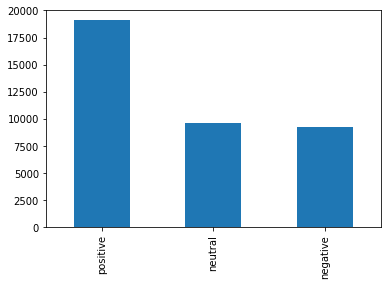

In [49]:
# Get percentage of tweets by polarity bucket (aka analysis)
df_cut3['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [51]:
df_cut3['Analysis'].value_counts(normalize=True)*100

positive    50.346208
neutral     25.245505
negative    24.408288
Name: Analysis, dtype: float64

In [53]:
view_neg = df_cut3.loc[df_cut3['Analysis'] == 'negative']

In [59]:
view_neg.tweet.sample(20)

24050    US taxpayer money funded a controversial healt...
13238     If you advocate for herd immunity without a v...
8387      That depends heavily on the adverse effects a...
32009    Hmm.. vaccine with minimal side effects that c...
11603    Covid related hospitalizations and deaths are ...
7798      Guys this is scary : Norway not the first rec...
7157      This vaccine programme in Scotland needs a se...
5933     just a reminder that yesterday california had ...
39830    Before we ask "what are the health impacts of ...
21048    Listening to  callers rn:  Host: "What's an is...
1762     _ns You'd think the sheer number of deaths and...
16562     Tough choice between the Coronavirus, Trump o...
16941     March 2022 - everyone’s gotten 2 doses, at le...
14168     The UK cant do mass testing, failed everybody...
20717     Vaccine? Anyone would think he had shares in ...
34764    A vaccine with potentially bad side effects or...
9925     There is a choice. We can allocate vaccines ac.

In [70]:
list(view_neg.tweet.sample(20))

["I am finding it difficult to discern what may be COVID vaccine side effects and what is just a normal part of being a 32 year old in Ohio, who hasn't seen the sun for 7+ days, during a national coup, a national&gt;global pandemic, in the healthcare field. Ya know?",
 'the thalidomide tragedy in the 50s/60s led to thousands of deaths and birth defects. it’s the reason why the vaccine development and administration process today is so heavily regulated',
 "British Army's Information Warfare Unit will be deployed to tackle anti-vaccine propaganda ahead of jab rollout  Bring it on, I'm not anti vax, just anti covid poison, my body my choice   ",
 'Anti-vaccine pseudoscience peddler Robert F. Kennedy, Jr. used baseball legend Hank Aaron’s death in a desperate attempt to fan hysteria over the coronavirus vaccine  ',
 "Never heard of Nipah virus?  Well, read this from the :  ‘The death rate for Nipah virus is up to 75% &amp; it has no vaccine. While the world focuses on Covid-19, scientists

In [194]:
# Take a look at a NEUTRAL set
view_neutral = df_cut3.loc[df_cut3['Analysis'] == 'neutral']
list(view_neutral.tweet.sample(25))

["Doctors Say CDC Should Warn People the Side Effects From COVID Vaccine Shots Won't Be ‘a Walk in the Park'  ",
 "UPDATE The PfizerBioNTech Covid-19 vaccine began leaving the company's Michigan factory on Sunday, set to be injected into the arms of millions of the most vulnerable Americans as the global death toll topped 1.6 million   Kalamazoo  ",
 "The Bill Gates funded World Health Organisation (WHO) has told South Africa to use the Ineffective AstraZeneca Vaccines. Earlier Mkhize said SA won't return these Vaccines, which have undisclosed side effects. Trust Western Puppets, Cyril and Mkhize to gamble with Citizens Lives.",
 '_Bird86 Prevent any restrictions on those who refuse a Covid-19 vaccination   ',
 'Pfizer coronavirus vaccine side effects and safety for COVID19Vaccine   ',
 '  If you CHOOSE to have the vaccine then you are protected. Let people CHOOSE!! If the choice is not to, thats their choice! It’s called freedom of choice, another freedom we will lose. Where does it e

In [195]:
# Take a look at a POSITIVE set
view_positive = df_cut3.loc[df_cut3['Analysis'] == 'positive']
list(view_positive.tweet.sample(25))

["This is not the first time my church has failed to protect it’s members. I won’t be silent and allow such misinformation to spread leading to more deaths. factsmatter Bishop tells Catholics not to jump on 'vaccine bandwagon’ - Los Angeles Times  ",
 'The flu vaccine is different every year but it still works and side effects are minimal. They know how to make these things. Spreading skepticism is really not helping right now when we’re already going to have problems with distribution and vaccination.',
 "So, I'm about 36 hours out from my 2nd vaccine.   Side effects: incredibly sore arm, achy muscles in chest, back, &amp; arms. Joint pain &amp; stiffness in my fingers. Some fatigue.  The second shot was definitely worse than the first, but still not horrible. I've had worse flu shots.",
 'Two lines I see every morning on my ride into work: COVID testing and a food pantry.   The vaccine is here and that’s fantastic but this pandemic is still far from over. Cases still skyrocketing and

In [81]:
# ISSUE: Difficulty with text and df flowing off the screen. Tried several possible things... but not able to resolve it.
# pd.set_option('display.max_colwidth', None)

In [196]:
# def display_text_max_col_width(df, width):
   # with pd.option_context('display.max_colwidth', width):
     #   print(df)

# display_text_max_col_width(df_cut3['Analysis'] == 'negative', 800).sample(20)

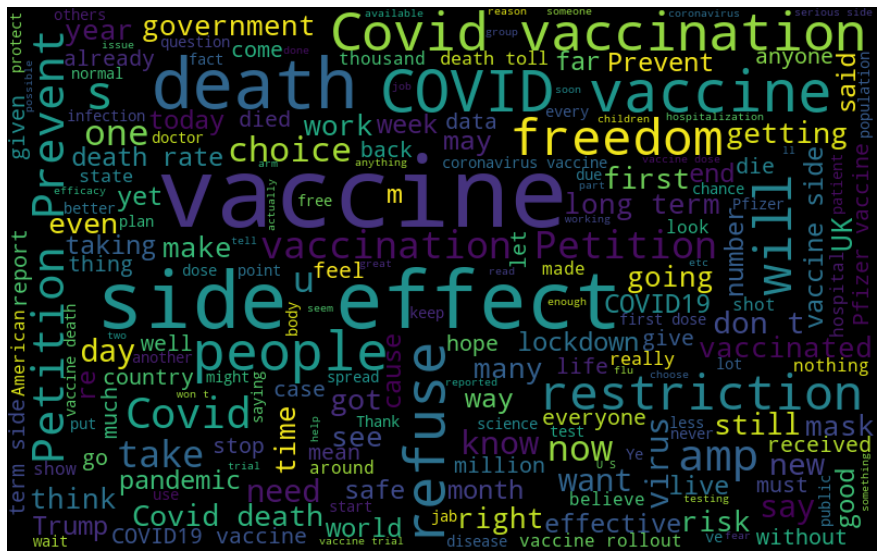

In [47]:
# Create word cloud of top occuring words - This is the full dataset (all polarities); also prior to stop words 
allwords = ' '.join([twts for twts in df_cut3['tweet']])

plt.figure(figsize=(16,10))
wordcloud = WordCloud(width=800, height=500, random_state=32, max_font_size=90).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
df_cut4 = df_cut3

## Begin LDA process

In [61]:
# TEXT Pre-processing for LDA
# Remove punctuation
df_cut4['text_processed'] = \
df_cut4['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_cut4['text_processed'] = \
df_cut4['text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_cut4['text_processed'].head()

<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-61-395322a9a935>:3: DeprecationWarning: invalid escape sequence \.
  df_cut4['text_processed'] = df_cut4['tweet'].m

0     it’s a death sentence for me if mine go back ...
1     it will start off as just a vaccine certifica...
2    happy that the uk is doing well with their vac...
3     remember folks this virus had a 997% survival...
4    4/ so where are these new cases and deaths com...
Name: text_processed, dtype: object

In [62]:
# Prepare the data for LDA analysis - adding in some additional stopwords based on the wordcloud above.

stop_words = stopwords.words('english')
stop_words.extend(['Covid', 'covid', 'vaccine', 'vaccination', 'rt', 'amp', 'http' ,'Vaccine', 'Vaccination', 'Covid vaccination', 'Covid vaccine'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_cut4.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['death', 'sentence', 'mine', 'go', 'back', 'th', 'march', 'exposed', 'yrr', 'cev', 'th', 'march', 'means', 'go', 'back', 'vulnerable', 'point', 'announced', 'survival', 'elite', 'fittest', 'screw', 'everybody', 'else']


In [63]:
# Create dictionary and corpus
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


In [64]:
# For the first model, am using 10 topics. 
# Train the model
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"prevent" + 0.032*"restrictions" + 0.031*"refuse" + 0.030*"petition" '
  '+ 0.025*"deaths" + 0.008*"effects" + 0.008*"vaccines" + 0.008*"side" + '
  '0.007*"people" + 0.006*"get"'),
 (1,
  '0.020*"vaccines" + 0.012*"deaths" + 0.010*"us" + 0.010*"death" + '
  '0.009*"side" + 0.009*"effects" + 0.007*"getting" + 0.006*"get" + '
  '0.006*"people" + 0.006*"first"'),
 (2,
  '0.018*"refuse" + 0.017*"people" + 0.017*"get" + 0.015*"vaccines" + '
  '0.015*"side" + 0.011*"effects" + 0.009*"virus" + 0.008*"death" + '
  '0.008*"health" + 0.007*"restrictions"'),
 (3,
  '0.026*"petition" + 0.023*"prevent" + 0.022*"refuse" + 0.021*"restrictions" '
  '+ 0.020*"people" + 0.012*"vaccines" + 0.011*"deaths" + 0.009*"death" + '
  '0.008*"choice" + 0.008*"freedom"'),
 (4,
  '0.021*"vaccines" + 0.015*"side" + 0.015*"effects" + 0.015*"people" + '
  '0.012*"deaths" + 0.009*"get" + 0.008*"death" + 0.007*"day" + 0.005*"refuse" '
  '+ 0.004*"health"'),
 (5,
  '0.093*"effects" + 0.090*"side" + 0.018*"

In [65]:
# Code to generate the interactive vizualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.008923 -0.085364       1        1  13.626482
5      0.111356 -0.035871       2        1  11.901030
3     -0.074595 -0.024561       3        1  11.169354
7      0.047757  0.012501       4        1  10.985969
1     -0.018081  0.047672       5        1   9.596703
0     -0.095491  0.032908       6        1   9.061087
2     -0.026400 -0.048837       7        1   8.978246
4     -0.021814  0.008079       8        1   8.452222
9     -0.005063  0.020943       9        1   8.223637
6      0.073409  0.072530      10        1   8.005267, topic_info=     Category          Freq          Term         Total  loglift  logprob
455   Default  16890.000000       effects  16890.000000  30.0000  30.0000
2165  Default   3664.000000      petition   3664.000000  29.0000  29.0000
461   Default  16977.000000          side  16977.000000  28.0000  28.0000
237   Default   4212.000000  restrictions   4212.000000  27.0000  27.0000
479   Default   4390.000000       prevent   4390.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
773   Topic10    194.835693          long   2036.559204   0.1782  -5.5558
232   Topic10    169.600647         would   2226.981201  -0.0499  -5.6945
495   Topic10    159.303864          time   1394.939453   0.3553  -5.7571
260   Topic10    165.025131           get   4437.724609  -0.7667  -5.7219
58    Topic10    165.930603      vaccines   8148.729492  -1.3690  -5.7164

[869 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
15183      2  0.840854  abnormalities
859        1  0.101848         accept
859        2  0.035647         accept
859        3  0.020370         accept
859        4  0.142588         accept
...      ...       ...            ...
2206       9  0.017259      yesterday
2206      10  0.502083      yesterday
8272       3  0.132166           zinc
8272       4  0.169928           zinc
8272       9  0.698593           zinc

[2841 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 4, 8, 2, 1, 3, 5, 10, 7])

In [68]:
# Another word cloud (full dataset) with stop words removed. 
stop_words = stopwords.words('english')
stop_words.extend(['Covid', 'covid', 'vaccine', 'vaccination', 'rt', 'amp', 'http' ,'Vaccine', 'Vaccination', 'Covid vaccination', 'Covid vaccine', 'vaccines', 'side', 'effects', 'retweet', 'people', 'deaths'])


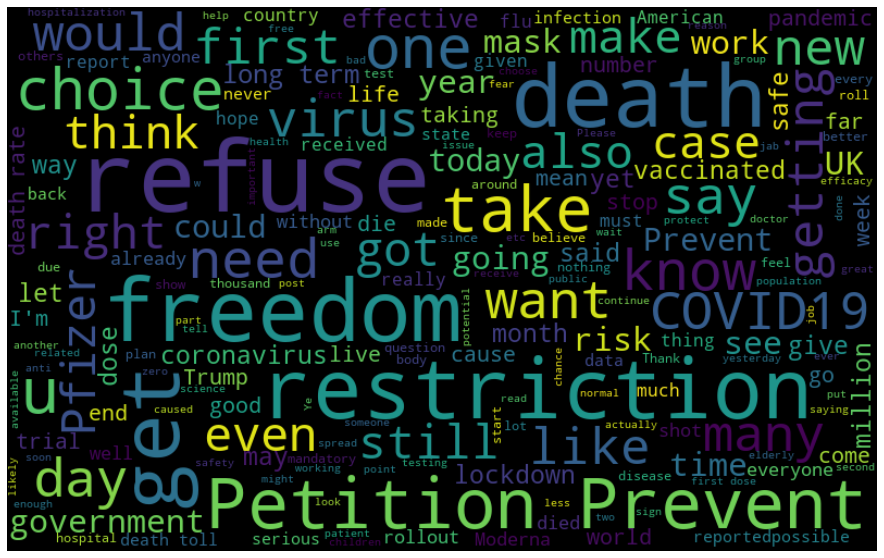

In [69]:
# Create word cloud of top occuring words
# allwords = ' '.join([twts for twts in df_cut3['tweet']])

plt.figure(figsize=(16,10))
wordcloud = WordCloud(stopwords=stop_words, max_words=200, width=800, height=500, random_state=32, max_font_size=90).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Observations on LDA and word cloud  - for full dataset
Can see that with 10 clusters there was some overlap of topics (5,8,9). So fewer topics may be better. The top occuring words overall were no suprise. There is a lot of repetition of words between the clusers so hard to id specific themes for each topi cluster. In the word cloud we see alot of words around a petition (to prevent restrictions); freedom and choice; death (related to side effects). 

### Conduct the analysis with just the negative set of tweets
Decided that I should further focus into just the tweets with negative sentiment (according to TextBlob classsification).

In [82]:
df_cut5 = df_cut3.loc[df_cut3['Analysis'] == 'negative']
df_cut5.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[],0.684091,-0.052273,negative,remember folks this virus had a 997% survival...
6,\n1363887707076837376,2021-02-22,kerry Hooper 🥀,Sick in a bag moment IDS wanting praise &amp...,en,7.0,14.0,"['borisjohnson', 'road2recovery', 'roadmap', '...",0.407937,-0.404762,negative,sick in a bag moment ids wanting praise &amp...
7,\n1363886935052324866,2021-02-22,Lawrence Gilder,DailyCovidUpdate | 22nd February 2021 - Cases...,en,70.0,115.0,['dailycovidupdate'],0.266667,-0.100000,negative,dailycovidupdate | 22nd february 2021 - cases...
20,\n1363876534579298316,2021-02-22,The Independent,"Pfizer vaccine is cutting infections, hospital...",en,9.0,41.0,[],0.900000,-0.600000,negative,pfizer vaccine is cutting infections hospitali...
22,\n1363876368044486657,2021-02-22,ITV News,Boris Johnson says Public Health England has f...,en,14.0,32.0,[],0.233333,-0.150000,negative,boris johnson says public health england has f...


In [83]:
# Create word cloud of top occuring words
allwords = ' '.join([twts for twts in df_cut5['tweet']])


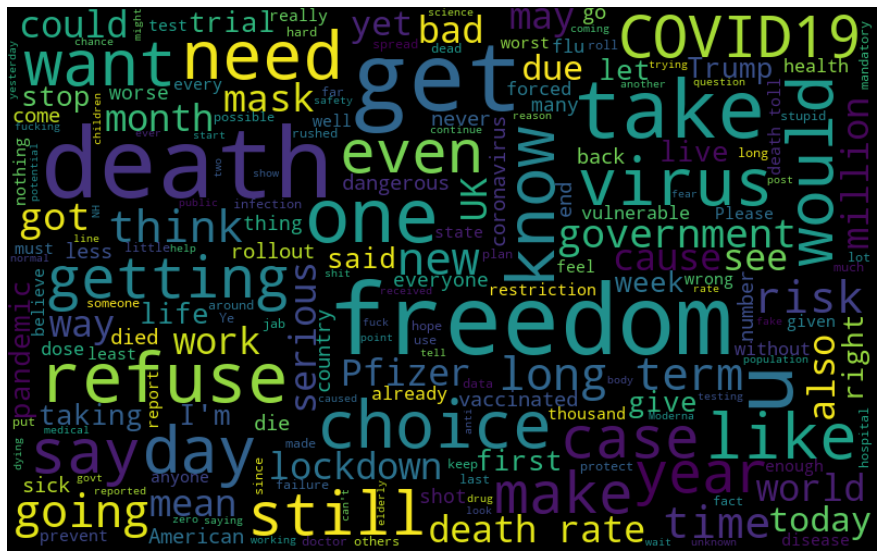

In [84]:
plt.figure(figsize=(16,10))
wordcloud = WordCloud(stopwords=stop_words, max_words=200, width=800, height=500, random_state=32, max_font_size=90).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
# 1 - TEXT Pre-processing
# Remove punctuation
df_cut5['text_processed'] = \
df_cut5['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_cut5['text_processed'] = \
df_cut5['text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_cut5['text_processed'].head()

<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-85-599e6b1be6d6>:3: DeprecationWarning: invalid escape sequence \.
  df_cut5['text_processed'] = df_cut5['tweet'].m

3      remember folks this virus had a 997% survival...
6     sick in a bag moment   ids wanting praise &amp...
7     dailycovidupdate | 22nd february 2021  - cases...
20    pfizer vaccine is cutting infections hospitali...
22    boris johnson says public health england has f...
Name: text_processed, dtype: object

In [86]:
# 2 - Prepare the data for LDA analysis

stop_words = stopwords.words('english')
stop_words.extend(['Covid', 'covid', 'vaccine', 'vaccination', 'rt', 'amp', 'http' ,'Vaccine', 'Vaccination', 'Covid vaccination', 'Covid vaccine', 'vaccines', 'side', 'effects', 'retweet', 'people', 'deaths', 'death', 'COVID19'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_cut5.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['remember', 'folks', 'virus', 'survival', 'rate', 'took', 'place', 'basically', 'sweet', 'fuck', 'rate', 'become', 'new', 'common', 'cold', 'hey', 'let', 'keep', 'crushing', 'economy', 'society', 'ground']


In [87]:
# 3 - Create dictionary and corpus
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]


In [88]:
# 4 - Train the model - here using 6 topics. 
from pprint import pprint
# number of topics
num_topics = 6
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"get" + 0.007*"us" + 0.006*"freedom" + 0.006*"one" + 0.005*"like" + '
  '0.004*"got" + 0.004*"pfizer" + 0.004*"getting" + 0.004*"need" + '
  '0.003*"going"'),
 (1,
  '0.011*"get" + 0.009*"refuse" + 0.007*"know" + 0.007*"take" + 0.005*"one" + '
  '0.005*"day" + 0.005*"need" + 0.005*"long" + 0.004*"like" + 0.004*"go"'),
 (2,
  '0.011*"freedom" + 0.008*"get" + 0.008*"long" + 0.007*"take" + 0.006*"dose" '
  '+ 0.006*"refuse" + 0.005*"virus" + 0.005*"want" + 0.004*"choice" + '
  '0.004*"term"'),
 (3,
  '0.011*"freedom" + 0.007*"one" + 0.006*"get" + 0.005*"cases" + 0.005*"like" '
  '+ 0.004*"us" + 0.004*"would" + 0.004*"could" + 0.004*"health" + '
  '0.004*"serious"'),
 (4,
  '0.007*"would" + 0.007*"get" + 0.006*"getting" + 0.006*"us" + 0.005*"like" + '
  '0.004*"term" + 0.004*"freedom" + 0.004*"know" + 0.004*"virus" + '
  '0.004*"long"'),
 (5,
  '0.007*"long" + 0.007*"term" + 0.007*"take" + 0.006*"serious" + 0.006*"get" '
  '+ 0.006*"refuse" + 0.005*"bad" + 0.005*"one" + 0.005

In [89]:
# 5 - Code to generate the interactive vizualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.011604  0.019219       1        1  20.514091
3     -0.047215  0.029178       2        1  17.452971
1      0.036931  0.015605       3        1  17.226122
5      0.015896 -0.054353       4        1  16.086311
4      0.020697  0.018368       5        1  14.585775
0     -0.037912 -0.028017       6        1  14.134732, topic_info=      Category         Freq      Term        Total  loglift  logprob
133    Default   555.000000      term   555.000000  30.0000  30.0000
186    Default   540.000000      know   540.000000  29.0000  29.0000
13333  Default   155.000000  petition   155.000000  28.0000  28.0000
3227   Default  1084.000000   freedom  1084.000000  27.0000  27.0000
169    Default   479.000000   getting   479.000000  26.0000  26.0000
...        ...          ...       ...          ...      ...      ...
2813    Topic6    75.434212    refuse   782.934509  -0.3833  -5.6972
46      Topic6    53.065758      year   300.760468   0.2218  -6.0489
132     Topic6    62.490250      take   827.094299  -0.6264  -5.8854
64      Topic6    56.602585    health   452.458374  -0.1221  -5.9844
20      Topic6    56.810257     virus   552.927612  -0.3190  -5.9807

[524 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1724       1  0.101252  absolutely
1724       2  0.119662  absolutely
1724       3  0.405010  absolutely
1724       4  0.092048  absolutely
1724       5  0.147276  absolutely
...      ...       ...         ...
724        4  0.115381         yet
724        5  0.084613         yet
724        6  0.211532         yet
13340      2  0.819279    yielding
13669      1  0.773323     yorself

[1299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 6, 5, 1])

#### Observations on the negative set of tweets and LDA topics
With 6 topics, we still see a bit of overlap (clusters 1,3,5). The main 4 topic areas sem to be related to the following: 
* news focused - several people mentioned (jan adolan, rahul shivshankar, bill gates, dolly parton)
* refuse due to bad side effects
* conspiracy theories - china, evil, scared, defective, plagued
* action - sign, petition, refuse
* political - colonial, globalism, extermination

I found that in order to get the more distinct words, it helps to use the slider above the bar chart and slide it to the left. This cuts out some of the more popular words that are repeated in multiple columns. 

### Examine a set of positive sentiment tweets to see if topics are any different

In [117]:
# Take a positive set from the combo-DF-of negative topics
df_cut7 = df_cut3.loc[df_cut3['Analysis'] == 'positive']
df_cut7.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certificate /passport but eventually will be used for so mu...,en,0.0,13.0,[],0.712500,0.362500,positive,it will start off as just a vaccine certificate /passport but eventually will be used for so mu...
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vaccines &amp; it's great to see hospital admissions ...,en,0.0,14.0,[],0.583333,0.533333,positive,happy that the uk is doing well with their vaccines &amp; it's great to see hospital admissions ...
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths coming from? The over-60 group is the group at risk. ...,en,18.0,83.0,[],0.404242,0.020606,positive,4/ so where are these new cases and deaths coming from the over-60 group is the group at risk se...
5,\n1363887730527260674,2021-02-22,Alex Berenson,3/ And the Israeli government claims nearly perfect effectiveness for the vaccine - 99% reductio...,en,18.0,84.0,[],0.538333,0.153333,positive,3/ and the israeli government claims nearly perfect effectiveness for the vaccine - 99% reductio...
8,\n1363886675844362248,2021-02-22,Alex Berenson,1/ I have to keep saying this: the Israeli’s government’s claims about how well the vaccine work...,en,172.0,350.0,[],0.430303,0.075758,positive,1/ i have to keep saying this: the israeli’s government’s claims about how well the vaccine work...


In [126]:
df_cut7.shape

(19123, 12)

In [127]:
list(df_cut7.tweet.sample(20))

["From my research I've found no account of COVID vaccines tested on the type of people likely to be encountered in care homes.  But yet it's being administered to them in large numbers &amp; media is reporting several deaths after these people have been vaccinated.  What's going on?",
 'People are literally going to die if they opt out of covid vaccination. If enough people refuse to get it when it’s available the pandemic won’t get much better.  The desire for vaccines is polling behind the 70%-80% ideal. You shouldn’t cause vaccine skepticism with bad takes.',
 "  So let me get this straight. If someone dies withing hours of receiving a vaccine it has nothing to do with the vaccine. But if they die withing 28 days of a so called COVID 19 positive RT-PCR test (which isn't a diagnostic test) it definitely a COVID 19 death. Yeah right!",
 'About 70% of registered voters surveyed said they would take a Covid-19 vaccine, although many want to wait until it has been available for a while 

In [118]:
# Create word cloud of top occuring words
allwords = ' '.join([twts for twts in df_cut7['tweet']])

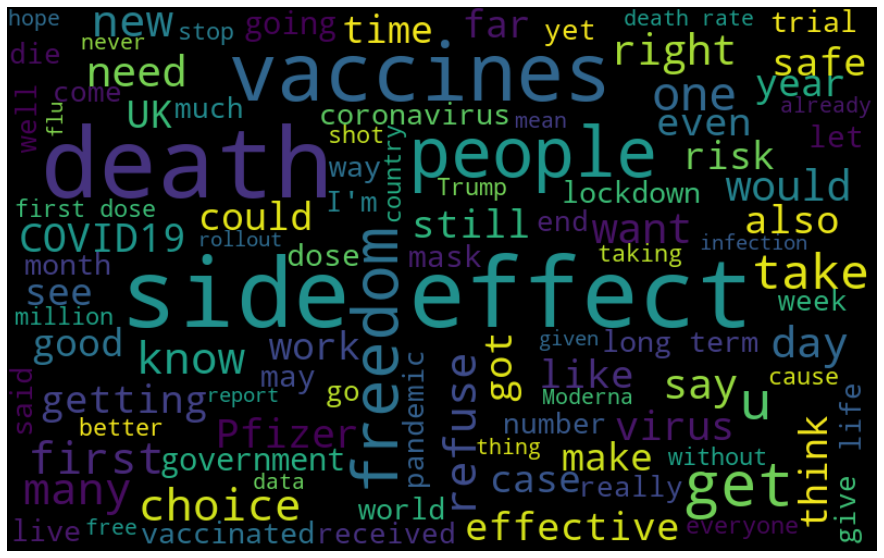

In [119]:
plt.figure(figsize=(16,10))
wordcloud = WordCloud(stopwords=stop_words, max_words=100, width=800, height=500, random_state=32, max_font_size=90).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [120]:
# 1 - TEXT Pre-processing
# Remove punctuation
df_cut7['text_processed'] = \
df_cut7['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_cut7['text_processed'] = \
df_cut7['text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_cut7['text_processed'].head()

<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-120-5a99902a4f8a>:3: DeprecationWarning: invalid escape sequence \.
  df_cut7['text_processed'] = df_cut7['tweet'].

1     it will start off as just a vaccine certificate /passport but eventually will be used for so mu...
2    happy that the uk is doing well with their vaccines &amp; it's great to see hospital admissions ...
4    4/ so where are these new cases and deaths coming from the over-60 group is the group at risk se...
5    3/ and the israeli government claims nearly perfect effectiveness for the vaccine - 99% reductio...
8    1/ i have to keep saying this: the israeli’s government’s claims about how well the vaccine work...
Name: text_processed, dtype: object

In [121]:
# 2 - Prepare the data for LDA analysis

stop_words = stopwords.words('english')
stop_words.extend(['Covid', 'covid', 'vaccine', 'vaccination', 'rt', 'amp', 'http' ,'Vaccine', 'Vaccination', 'Covidvaccination', 'Covidvaccine', 'vaccines', 'vaccinated', 'side', 'effects', 'retweet', 'people', 'deaths', 'death', 'COVID19'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_cut7.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['start', 'certificate', 'passport', 'eventually', 'used', 'much', 'think', 'liberate', 'ultimately', 'enslave', 'rapidly', 'becoming', 'better', 'option']


In [122]:
# 3 - Create dictionary and corpus
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [123]:
# 4 - Train the model
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"get" + 0.006*"new" + 0.006*"virus" + 0.006*"like" + 0.006*"freedom" '
  '+ 0.005*"know" + 0.005*"good" + 0.005*"safe" + 0.005*"us" + 0.005*"right"'),
 (1,
  '0.007*"many" + 0.007*"take" + 0.007*"effective" + 0.007*"get" + '
  '0.006*"long" + 0.006*"trial" + 0.005*"freedom" + 0.005*"coronavirus" + '
  '0.005*"one" + 0.005*"safe"'),
 (2,
  '0.013*"first" + 0.007*"new" + 0.006*"one" + 0.006*"trials" + 0.005*"know" + '
  '0.005*"us" + 0.005*"dose" + 0.005*"cases" + 0.005*"pfizer" + 0.005*"shot"'),
 (3,
  '0.011*"freedom" + 0.006*"get" + 0.005*"choice" + 0.004*"going" + '
  '0.004*"would" + 0.004*"time" + 0.004*"us" + 0.004*"today" + 0.004*"many" + '
  '0.004*"new"')]


In [124]:
# 5 - Code to generate the interactive vizualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001698  0.003273       1        1  30.472738
2     -0.029809  0.046846       2        1  26.799988
1     -0.027526 -0.050378       3        1  21.901997
3      0.059033  0.000259       4        1  20.825274, topic_info=     Category         Freq       Term        Total  loglift  logprob
136   Default  2050.000000      first  2050.000000  30.0000  30.0000
1352  Default   739.000000      trial   739.000000  29.0000  29.0000
1869  Default  2040.000000    freedom  2040.000000  28.0000  28.0000
248   Default  1156.000000  effective  1156.000000  27.0000  27.0000
581   Default   786.000000       term   786.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
1822   Topic4   182.015518       want   850.337830   0.0275  -5.9212
87     Topic4   186.207733       even   985.708984  -0.0975  -5.8985
768    Topic4   180.869980      right   926.774719  -0.0649  -5.9275
136    Topic4   199.677795      first  2050.737549  -0.7602  -5.8286
55     Topic4   166.314346       dose   973.813354  -0.1983  -6.0114

[383 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
6840       1  0.063270     aches
6840       2  0.885786     aches
6840       3  0.025308     aches
6840       4  0.037962     aches
9722       2  0.098981     alarm
...      ...       ...       ...
21766      2  0.975837       себ
17171      1  0.040517  чувствую
17171      2  0.931885  чувствую
17171      3  0.013506  чувствую
17171      4  0.013506  чувствую

[879 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

#### Observations on the positive sentiment tweets
Here I found that with 4 topic clusters the clusters were dispersed. Overall, the topics were similar to the negative set. However, some positve words were seen... things around getting vaccinated or wantingt oget vaccinated, or about when or which vaccination (1st or 2nd).

## Complete Analysis with a more neutral to positive dataset
Next, I wanted to check to see if I examined tweets with more neutral keywords - "covid vaccination" would result in different findings. So this is the similar process applied to a different pull of tweets using Twint. 

In [91]:
df_start = pd.read_csv('data/cvacntn2.csv', sep='\t', lineterminator='\r')
print(df_start.shape)
df_start.head()

(28715, 36)


/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1363893645196333057,1.363894e+18,2021-02-22 08:49:19 PST,2021-02-22,08:49:19,-800.0,2.290538e+09,dominicmc999,Dom Mcloughlin. ‼️😷MASKS SAVE LIVES😷‼️,NaN,I can’t thank enough the many scientists for t...,en,[],[],[],1.0,3.0,15.0,[],[],https://twitter.com/DominicMc999/status/136389...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1363892158399324170,1.363892e+18,2021-02-22 08:43:25 PST,2021-02-22,08:43:25,-800.0,1.989714e+07,indiatoday,IndiaToday,NaN,5 states reported a spike in COVID-19 cases ag...,en,"[{'screen_name': 'snehamordani', 'name': 'sneh...",[],[],2.0,3.0,24.0,[],[],https://twitter.com/IndiaToday/status/13638921...,False,NaN,1.0,https://pbs.twimg.com/amplify_video_thumb/1363...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1363891979084570629,1.363892e+18,2021-02-22 08:42:42 PST,2021-02-22,08:42:42,-800.0,6.464306e+07,rt_com,RT,NaN,‘Why would anyone get the jab after this?’: AP...,en,[],['https://on.rt.com/b2df'],['https://pbs.twimg.com/media/Eu2EZzlXAAYZyqa....,2.0,11.0,18.0,['covid'],[],https://twitter.com/RT_com/status/136389197908...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2EZzlXAAYZyqa.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1363890915467800576,1.363891e+18,2021-02-22 08:38:28 PST,2021-02-22,08:38:28,-800.0,3.814266e+07,le_parisien,Le Parisien,NaN,🔴 La vaccination contre le Covid sera possible...,fr,[],['https://l.leparisien.fr/vZsw'],['https://pbs.twimg.com/media/Eu2DjxrXcAEln88....,4.0,14.0,20.0,['covidー19'],[],https://twitter.com/le_Parisien/status/1363890...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2DjxrXcAEln88.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1363887481217830915,1.363887e+18,2021-02-22 08:24:49 PST,2021-02-22,08:24:49,-800.0,1.346792e+18,vaccinestatusuk,UK COVID-19 Vaccine Tracker,NaN,"17,723,840 individuals in the UK🇬🇧 received at...",en,[],[],['https://pbs.twimg.com/media/Eu2AUCgXEAIZ8X3....,1.0,3.0,16.0,"['vaccine', 'vaccination']",[],https://twitter.com/VaccineStatusUK/status/136...,False,NaN,1.0,https://pbs.twimg.com/media/Eu2AUCgXEAIZ8X3.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [92]:
# Remove unneeded columns
df_cuta = df_start.drop(columns=['conversation_id', 'created_at', 'time', 'timezone',
       'user_id', 'username', 'mentions',
       'urls', 'photos', 'replies_count', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], axis=1)
df_cuta.head()

,id,date,name,place,tweet,language,retweets_count,likes_count,hashtags,near,geo
0,1363893645196333057,2021-02-22,Dom Mcloughlin. ‼️😷MASKS SAVE LIVES😷‼️,NaN,I can’t thank enough the many scientists for t...,en,3.0,15.0,[],NaN,NaN
1,1363892158399324170,2021-02-22,IndiaToday,NaN,5 states reported a spike in COVID-19 cases ag...,en,3.0,24.0,[],NaN,NaN
2,1363891979084570629,2021-02-22,RT,NaN,‘Why would anyone get the jab after this?’: AP...,en,11.0,18.0,['covid'],NaN,NaN
3,1363890915467800576,2021-02-22,Le Parisien,NaN,🔴 La vaccination contre le Covid sera possible...,fr,14.0,20.0,['covidー19'],NaN,NaN
4,1363887481217830915,2021-02-22,UK COVID-19 Vaccine Tracker,NaN,"17,723,840 individuals in the UK🇬🇧 received at...",en,3.0,16.0,"['vaccine', 'vaccination']",NaN,NaN


In [93]:
df_cuta = df_cuta.drop(columns=['place', 'near', 'geo'], axis=1)
df_cuta.shape

(28715, 8)

In [94]:
df_cuta = df_cuta.loc[df_cuta['language'] == 'en']
df_cuta.shape

(25896, 8)

In [95]:
df_cuta = df_cuta.loc[df_cuta['date'] > "2020-02-20"]
df_cuta.shape

(25894, 8)

In [96]:
# Check for duplicate rows
duplicate = df_cuta[df_cuta.duplicated()]
duplicate.shape

(0, 8)

In [97]:
print("Columns with null values")
display(df_cuta.isnull().sum())

Columns with null values


id                0
date              0
name              0
tweet             0
language          0
retweets_count    0
likes_count       0
hashtags          0
dtype: int64

In [98]:
df_cutb = df_cuta

### Begin NLP - for new dataset - keywords "covid vaccination"

In [128]:
pd.set_option('display.max_colwidth', 80)

In [100]:
# START wiht TextBlob processing and sentiment assignment.
# First strip out special charachters in the tweets
# Strip out @, #, RT, and url from tweets
def cleantext (text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

df_cutb['tweet'] = df_cuta['tweet'].apply(cleantext)

In [101]:
# Add subjectivity and polarity scores from TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df_cutb['subjectivity'] = df_cutb['tweet'].apply(getSubjectivity)
df_cutb['polarity'] = df_cutb['tweet'].apply(getPolarity)
df_cutb.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity
0,1363893645196333057,2021-02-22,Dom Mcloughlin. ‼️😷MASKS SAVE LIVES😷‼️,I can’t thank enough the many scientists for their fabulous development of what I believe are 💯%...,en,3.0,15.0,[],0.642857,0.371429
1,1363892158399324170,2021-02-22,IndiaToday,"5 states reported a spike in COVID-19 cases again. On the other hand, India may have to rework t...",en,3.0,24.0,[],0.591667,0.125000
2,1363891979084570629,2021-02-22,RT,‘Why would anyone get the jab after this?’: AP criticized for saying COVID vaccination WON’T bri...,en,11.0,18.0,['covid'],0.325000,0.075000
4,1363887481217830915,2021-02-22,UK COVID-19 Vaccine Tracker,"17,723,840 individuals in the UK🇬🇧 received at least one dose of a COVID vaccine💉 as of 22 Febru...",en,3.0,16.0,"['vaccine', 'vaccination']",0.350000,-0.100000
5,1363883815647801347,2021-02-22,ALT US INS (OG Immigration),Here we go with Megyn whining about how difficult the virus is for her and that the vaccination...,en,3.0,25.0,[],1.000000,-0.333333


In [102]:
df_cutb['polarity'].describe()

count    25894.000000
mean         0.141009
std          0.240109
min         -1.000000
25%          0.000000
50%          0.100000
75%          0.266667
max          1.000000
Name: polarity, dtype: float64

In [103]:
df_cutb['subjectivity'].describe()

count    25894.000000
mean         0.389380
std          0.270059
min          0.000000
25%          0.183333
50%          0.400000
75%          0.562500
max          1.000000
Name: subjectivity, dtype: float64

In [104]:
# Group the tweets by positive, negative, or neutral based on Polarity score
def getanalysis (score):
    if score <0:
        return "negative"
    elif score ==0:
        return "neutral"
    else:
        return "positive"
    
df_cutb['Analysis'] = df_cutb['polarity'].apply(getanalysis)
df_cutb.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis
0,1363893645196333057,2021-02-22,Dom Mcloughlin. ‼️😷MASKS SAVE LIVES😷‼️,I can’t thank enough the many scientists for their fabulous development of what I believe are 💯%...,en,3.0,15.0,[],0.642857,0.371429,positive
1,1363892158399324170,2021-02-22,IndiaToday,"5 states reported a spike in COVID-19 cases again. On the other hand, India may have to rework t...",en,3.0,24.0,[],0.591667,0.125000,positive
2,1363891979084570629,2021-02-22,RT,‘Why would anyone get the jab after this?’: AP criticized for saying COVID vaccination WON’T bri...,en,11.0,18.0,['covid'],0.325000,0.075000,positive
4,1363887481217830915,2021-02-22,UK COVID-19 Vaccine Tracker,"17,723,840 individuals in the UK🇬🇧 received at least one dose of a COVID vaccine💉 as of 22 Febru...",en,3.0,16.0,"['vaccine', 'vaccination']",0.350000,-0.100000,negative
5,1363883815647801347,2021-02-22,ALT US INS (OG Immigration),Here we go with Megyn whining about how difficult the virus is for her and that the vaccination...,en,3.0,25.0,[],1.000000,-0.333333,negative


positive    60.203136
neutral     24.812698
negative    14.984166
Name: Analysis, dtype: float64


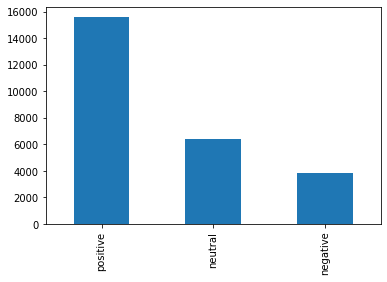

In [105]:
# Get percentage of tweets by polarity bucket (aka analysis)
print(df_cutb['Analysis'].value_counts(normalize=True)*100)
df_cutb['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [106]:
view_neg = df_cutb.loc[df_cutb['Analysis'] == 'negative']

In [107]:
# Read over a sample of the tweets for context and deeper understanding. 
list(view_neg.tweet.sample(20))

['We support this risk based approach that means clinically vulnerable pregnant women &amp; breastfeeding women will now have access to COVID-19 vaccination, until data exist to support routine vaccination in pregnancy',
 'Dubious websites and social media posts are falsely accusing a member of President-elect Joe Biden’s COVID-19 advisory team of wanting to mandate vaccination by tying it to food assistance.   FactCHAT',
 'COVID-19 is 10 times deadlier for people with Down syndrome, raising calls for early vaccination  ',
 'Disappointed that a New York hospital canceled my Covid  vaccination scheduled for a few days from now. It doesn’t have enough, it says. I’m sure the distribution will be sorted out before too long but, jeez, this is one lousy, ill-coordinated rollout.',
 ' please help us get the second vaccination on schedule I don’t want to get covid just cause I’m a nurse, I don’t want to bring it home to my disabled daughter   _Wish ',
 'An excellent GP tells me Covid "takes me

In [109]:
# Select just the negative sentiment tweets
df_cutc = df_cutb.loc[df_cutb['Analysis'] == 'negative']
df_cutc.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis
4,1363887481217830915,2021-02-22,UK COVID-19 Vaccine Tracker,"17,723,840 individuals in the UK🇬🇧 received at least one dose of a COVID vaccine💉 as of 22 Febru...",en,3.0,16.0,"['vaccine', 'vaccination']",0.350000,-0.100000,negative
5,1363883815647801347,2021-02-22,ALT US INS (OG Immigration),Here we go with Megyn whining about how difficult the virus is for her and that the vaccination...,en,3.0,25.0,[],1.000000,-0.333333,negative
17,1363874272486252546,2021-02-22,(((Shane))),Just got my COVID vaccination. If I should happen turn into a rage zombie just remember grrr arg...,en,0.0,18.0,[],0.800000,-0.700000,negative
18,1363873899470082058,2021-02-22,*Walter Bloomberg,*UK Data Show 57% Fewer Observed Cases Than Expected Among Over 80s 28 Days After Single Dose *...,en,7.0,31.0,[],0.307143,-0.085714,negative
50,1363843487104344067,2021-02-22,Pirates,Our partnership with keeps growing stronger. On Saturday we teamed-up with AHN for our second m...,en,6.0,98.0,[],0.200000,-0.100000,negative


In [125]:
df_cutc.shape

(3880, 12)

## Begin LDA process

In [111]:
# 1 - TEXT Pre-processing
# Remove punctuation
df_cutc['text_processed'] = \
df_cutc['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_cutc['text_processed'] = \
df_cutc['text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df_cutc['text_processed'].head()

<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<input>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-111-0da7a098416e>:3: DeprecationWarning: invalid escape sequence \.
  df_cutc['text_processed'] = df_cutc['tweet'].

4     17723840 individuals in the uk🇬🇧 received at least one dose of a covid vaccine💉 as of 22 februar...
5      here we go with megyn whining about how difficult the virus is for her and that the vaccination...
17    just got my covid vaccination if i should happen turn into a rage zombie just remember grrr argg...
18    *uk data show 57% fewer observed cases than expected among over 80s 28 days after single dose  *...
50    our partnership with  keeps growing stronger on saturday we teamed-up with ahn for our second ma...
Name: text_processed, dtype: object

In [112]:
# 2 - Prepare the data for LDA analysis

stop_words = stopwords.words('english')
stop_words.extend(['Covid', 'covid', 'vaccine', 'vaccination', 'rt', 'amp', 'http' , 'site', 'today', 'Vaccine', 'Vaccination', 'Covid vaccination', 'Covid vaccine'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_cutc.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['individuals', 'uk', 'received', 'least', 'one', 'dose', 'february', 'adult', 'population', 'priority', 'groups']


In [113]:
# 3 - Create dictionary and corpus
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


In [114]:
# 4 - Train the model
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"people" + 0.005*"us" + 0.004*"vaccinated" + 0.004*"would" + '
  '0.004*"health" + 0.004*"vaccines" + 0.003*"one" + 0.003*"going" + '
  '0.003*"get" + 0.003*"time"'),
 (1,
  '0.010*"people" + 0.009*"get" + 0.006*"health" + 0.004*"one" + 0.004*"us" + '
  '0.004*"uk" + 0.004*"take" + 0.003*"care" + 0.003*"black" + 0.003*"week"'),
 (2,
  '0.009*"people" + 0.006*"get" + 0.006*"need" + 0.005*"health" + '
  '0.005*"vaccinated" + 0.004*"vaccines" + 0.004*"us" + 0.003*"due" + '
  '0.003*"still" + 0.003*"staff"'),
 (3,
  '0.006*"get" + 0.005*"one" + 0.005*"people" + 0.004*"mass" + 0.003*"country" '
  '+ 0.003*"new" + 0.003*"year" + 0.003*"day" + 0.003*"us" + 0.003*"news"')]


In [115]:
# 5 - Code to generate the interactive vizualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.026327 -0.049659       1        1  28.053055
0      0.008255  0.008890       2        1  24.651197
2      0.023975  0.043876       3        1  23.738644
3     -0.058556 -0.003108       4        1  23.557108, topic_info=    Category        Freq        Term       Total  loglift  logprob
661  Default  167.000000        need  167.000000  30.0000  30.0000
149  Default  403.000000         get  403.000000  29.0000  29.0000
0    Default   23.000000       adult   23.000000  28.0000  28.0000
438  Default   68.000000          pm   68.000000  27.0000  27.0000
107  Default  146.000000       would  146.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
271   Topic4   38.108681      health  290.560669  -0.5856  -5.9913
257   Topic4   32.268429        take  161.074310  -0.1620  -6.1577
460   Topic4   29.642843    pandemic  125.887993  -0.0004  -6.2426
900   Topic4   28.963976        like  140.646057  -0.1345  -6.2657
341   Topic4   28.975285  vaccinated  206.053192  -0.5159  -6.2653

[367 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1395      1  0.107414  accused
1395      2  0.107414  accused
1395      3  0.107414  accused
1395      4  0.751901  accused
182       1  0.223975   across
...     ...       ...      ...
1402      4  0.885788  wrongly
87        1  0.266037     year
87        2  0.174300     year
87        3  0.165127     year
87        4  0.403643     year

[768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

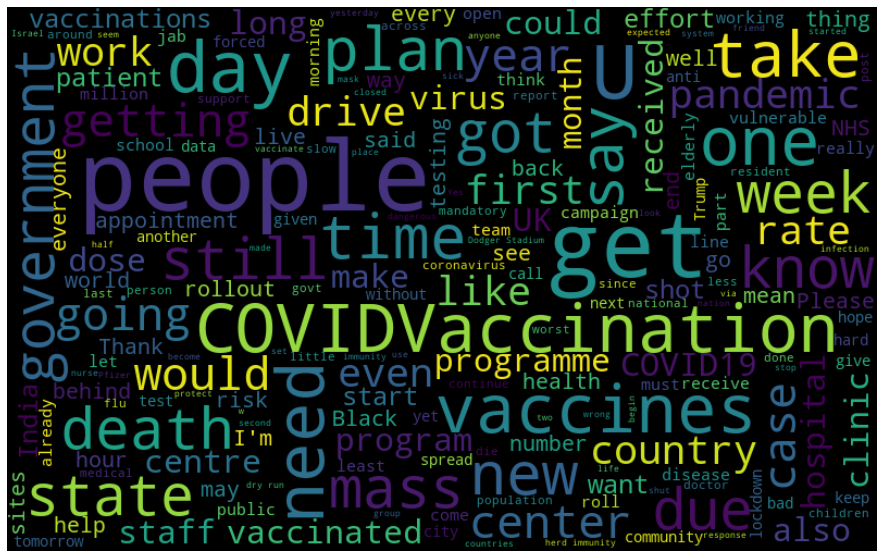

In [116]:
plt.figure(figsize=(16,10))
wordcloud = WordCloud(stopwords=stop_words, max_words=200, width=800, height=500, random_state=32, max_font_size=90).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Observations on negative tweets from the more neutral subject of "covid vaccination"
Did not notice any substantial differences from what I saw earlier.

## Try approach C - with different code for doing some EDA on top words, bi-grams and tri-grams. 
For this I will use the combo dataset of negative topics, and utilize the negative sentimet set. So this is about 25% of that dataset (~9K). 

In [129]:
df_cut5.shape

(9271, 12)

In [137]:
pd.set_option('display.max_colwidth', 50)

In [138]:
df_cut5.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[],0.684091,-0.052273,negative,remember folks this virus had a 997% survival...
6,\n1363887707076837376,2021-02-22,kerry Hooper 🥀,Sick in a bag moment IDS wanting praise &amp...,en,7.0,14.0,"['borisjohnson', 'road2recovery', 'roadmap', '...",0.407937,-0.404762,negative,sick in a bag moment ids wanting praise &amp...
7,\n1363886935052324866,2021-02-22,Lawrence Gilder,DailyCovidUpdate | 22nd February 2021 - Cases...,en,70.0,115.0,['dailycovidupdate'],0.266667,-0.100000,negative,dailycovidupdate | 22nd february 2021 - cases...
20,\n1363876534579298316,2021-02-22,The Independent,"Pfizer vaccine is cutting infections, hospital...",en,9.0,41.0,[],0.900000,-0.600000,negative,pfizer vaccine is cutting infections hospitali...
22,\n1363876368044486657,2021-02-22,ITV News,Boris Johnson says Public Health England has f...,en,14.0,32.0,[],0.233333,-0.150000,negative,boris johnson says public health england has f...


In [130]:
# Create a pipeline to clean the text
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [139]:
def clean_tweetn(tweetn):
    tweetn = "".join([word for word in tweetn if word not in string.punctuation])
    tokens = re.split('\W+', tweetn)
    tweetn = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return tweetn

df_cut5['tweet_clean'] = df_cut5['tweet'].apply(lambda x: clean_tweetn(x.lower()))

<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-139-d2bc9ab9f3e2>:3: DeprecationWarning: invalid escape sequence \W
  tokens = re.split('\W+', tweetn)
/Users/markp

In [140]:
df_cut5.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed,tweet_clean
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% surviva...,en,2.0,26.0,[],0.684091,-0.052273,negative,remember folks this virus had a 997% survival...,"[, remember, folk, virus, 997, survival, rate,..."
6,\n1363887707076837376,2021-02-22,kerry Hooper 🥀,Sick in a bag moment IDS wanting praise &amp...,en,7.0,14.0,"['borisjohnson', 'road2recovery', 'roadmap', '...",0.407937,-0.404762,negative,sick in a bag moment ids wanting praise &amp...,"[sick, bag, moment, id, wanting, praise, amp, ..."
7,\n1363886935052324866,2021-02-22,Lawrence Gilder,DailyCovidUpdate | 22nd February 2021 - Cases...,en,70.0,115.0,['dailycovidupdate'],0.266667,-0.100000,negative,dailycovidupdate | 22nd february 2021 - cases...,"[dailycovidupdate, 22nd, february, 2021, case,..."
20,\n1363876534579298316,2021-02-22,The Independent,"Pfizer vaccine is cutting infections, hospital...",en,9.0,41.0,[],0.900000,-0.600000,negative,pfizer vaccine is cutting infections hospitali...,"[pfizer, vaccine, cutting, infection, hospital..."
22,\n1363876368044486657,2021-02-22,ITV News,Boris Johnson says Public Health England has f...,en,14.0,32.0,[],0.233333,-0.150000,negative,boris johnson says public health england has f...,"[boris, johnson, say, public, health, england,..."


In [141]:
#most frequent and least frequent words 
negative_list = []  # list containing all words of all texts
for x in df_cut5['tweet_clean']:  # loop over lists in df
    negative_list += x  # append elements of lists to full list

neg_val_counts = pd.Series(negative_list).value_counts()  # make temporary Series to count
neg_val_counts

vaccine         10569
                 5889
death            4794
effect           3098
side             2973
                ...  
hexavalent          1
hepatic             1
blinding            1
technofanart        1
pasta               1
Length: 18029, dtype: int64

In [170]:
pd.set_option('display.max_rows', 100)

In [171]:
neg_val_counts[:100]

vaccine        10569
                5889
death           4794
effect          3098
side            2973
covid           2649
people          2056
freedom         1485
covid19         1471
amp             1400
get             1386
u                958
take             922
vaccination      860
one              811
day              684
case             672
virus            662
like             662
refuse           636
choice           611
would            609
know             603
year             588
need             587
long             577
rate             576
dont             541
want             529
even             517
say              508
getting          505
health           504
life             502
still            482
mask             473
make             463
time             444
serious          444
going            438
risk             438
bad              420
government       414
term             404
month            402
think            397
2                395
trial        

In [153]:
# MORE ISSUES with trying to adjust the display and the run off the page problem.
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)

pd.set_option("display.max_rows", 50, "display.max_columns", 60)

In [155]:
pd.set_option('display.max_colwidth', 60)

In [156]:
df_cut5.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed,tweet_clean
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% survival rate bef...,en,2.0,26.0,[],0.684091,-0.052273,negative,remember folks this virus had a 997% survival rate befo...,"[, remember, folk, virus, 997, survival, rate, vaccine, ..."
6,\n1363887707076837376,2021-02-22,kerry Hooper 🥀,Sick in a bag moment IDS wanting praise &amp; applauds...,en,7.0,14.0,"['borisjohnson', 'road2recovery', 'roadmap', 'toryfail']",0.407937,-0.404762,negative,sick in a bag moment ids wanting praise &amp; applauds...,"[sick, bag, moment, id, wanting, praise, amp, applauds, ..."
7,\n1363886935052324866,2021-02-22,Lawrence Gilder,"DailyCovidUpdate | 22nd February 2021 - Cases: 4,126,15...",en,70.0,115.0,['dailycovidupdate'],0.266667,-0.100000,negative,dailycovidupdate | 22nd february 2021 - cases: 4126150 ...,"[dailycovidupdate, 22nd, february, 2021, case, 4126150, ..."
20,\n1363876534579298316,2021-02-22,The Independent,"Pfizer vaccine is cutting infections, hospitalisations a...",en,9.0,41.0,[],0.900000,-0.600000,negative,pfizer vaccine is cutting infections hospitalisations an...,"[pfizer, vaccine, cutting, infection, hospitalisation, d..."
22,\n1363876368044486657,2021-02-22,ITV News,Boris Johnson says Public Health England has found that ...,en,14.0,32.0,[],0.233333,-0.150000,negative,boris johnson says public health england has found that ...,"[boris, johnson, say, public, health, england, found, on..."


<AxesSubplot:title={'center':'Parts of Speech in Negative Tweets'}>

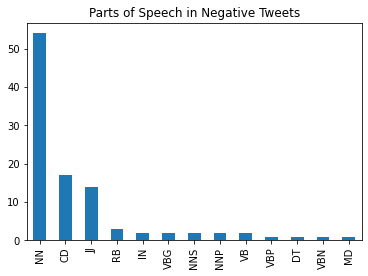

In [162]:
# Plot the parts of speech
blob = TextBlob(str(df_cut5['tweet_clean']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind='bar', title="Parts of Speech in Negative Tweets")

In [172]:
(pd.Series(nltk.ngrams(negative_list, 2)).value_counts())[:100]

(side, effect)              2908
(, )                         921
(covid, vaccine)             856
(covid19, vaccine)           571
(long, term)                 336
(covid, death)               332
(death, rate)                321
(vaccine, )                  317
(get, vaccine)               316
(effect, vaccine)            302
(vaccine, side)              300
(take, vaccine)              238
(, vaccine)                  218
(term, side)                 199
(vaccine, rollout)           197
(covid19, vaccination)       193
(death, toll)                191
(serious, side)              162
(pfizer, vaccine)            160
(death, )                    142
(effect, )                   136
(death, vaccine)             133
(wear, mask)                 130
(refuse, covid19)            124
(vaccine, death)             123
(getting, vaccine)           123
(coronavirus, vaccine)       121
(care, home)                 110
(vaccine, trial)             107
(restriction, refuse)        104
(covid19, 

In [173]:
(pd.Series(nltk.ngrams(negative_list, 3)).value_counts())[:100]

(vaccine, side, effect)                    297
(side, effect, vaccine)                    275
(term, side, effect)                       195
(long, term, side)                         187
(serious, side, effect)                    161
(side, effect, )                           129
(refuse, covid19, vaccination)             116
(restriction, refuse, covid19)             100
(prevent, restriction, refuse)              96
(petition, prevent, restriction)            90
(side, effect, covid)                       69
(possible, side, effect)                    68
(vaccine, , )                               66
(bad, side, effect)                         62
(covid, vaccine, side)                      53
(longterm, side, effect)                    51
(potential, side, effect)                   50
(effect, covid, vaccine)                    49
(, , vaccine)                               48
(death, rate, world)                        46
(know, side, effect)                        45
(vaccine, 1st

#### Observations on Top Words, Bi-grams, Tri-grams - for the negative sentiment tweets
This method worked well for quickly generating lists of top words, bi-grams, and tri-grams. The bi-grams are a big help in improving understanding of single words; tri-grms did not add much more understanding - at least with this data set. 
Some of the top words and combinations included: 
* serious, side, effect
* long, term, side
* petition, prevent, restrictions
* freedom, choice 
* freedom, medical
* rushed, vaccine
* bill, gate

It is still important to read over a sample of the tweets for deeper understanding and context. This was an important part of this analysis as well. Some of the key themes that emerged from the negative sentiment tweets were: 
* vaccine itself: ineffective, rushed, not thoroughly tested, side effects / long term / deaths
* process: forced, lack of choice = lack of freedom, status tracked, denial of services if not vaccinated
* actions: sign petition to prevent restrictions, protest close vaccination site
* blame or source: microchip to track you; medical experiment; Bill Gates, WHO, Democrats, government, big pharma, the church

### Like this approach... lets go through the neutral and positives too. 

In [174]:
df_cut3.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back on 8th Ma...,en,2.0,12.0,[],0.250000,0.000000,neutral,it’s a death sentence for me if mine go back on 8th mar...
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certificate /passpo...,en,0.0,13.0,[],0.712500,0.362500,positive,it will start off as just a vaccine certificate /passpo...
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vaccines &amp...,en,0.0,14.0,[],0.583333,0.533333,positive,happy that the uk is doing well with their vaccines &amp...
3,\n1363889576583065600,2021-02-22,Adam Knight,Remember folks this virus had a 99.7% survival rate bef...,en,2.0,26.0,[],0.684091,-0.052273,negative,remember folks this virus had a 997% survival rate befo...
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths coming from? ...,en,18.0,83.0,[],0.404242,0.020606,positive,4/ so where are these new cases and deaths coming from t...


In [176]:
df3a_neutral = df_cut3.loc[df_cut3['Analysis'] == 'neutral']
print(df3a_neutral.shape)
df3a_neutral.head()

(9589, 12)


,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back on 8th Ma...,en,2.0,12.0,[],0.25,0.0,neutral,it’s a death sentence for me if mine go back on 8th mar...
29,\n1363873071069806592,2021-02-22,🔥This Is Fine🔥 Too 🔥,"People screeching ""no vaccines for anti-maskers"" is peak...",en,5.0,17.0,[],0.00,0.0,neutral,"people screeching ""no vaccines for anti-maskers"" is peak..."
33,\n1363867929377390596,2021-02-22,The Hill,Israel: Pfizer vaccine prevents 98.9 percent of COVID-19...,en,68.0,286.0,[],0.00,0.0,neutral,israel: pfizer vaccine prevents 989 percent of covid-19 ...
43,\n1363855246506811394,2021-02-22,Graham Hutchinson,What is irresponsible is introducing an untested vaccine...,en,41.0,127.0,[],0.00,0.0,neutral,what is irresponsible is introducing an untested vaccine...
48,\n1363848291570581508,2021-02-22,The Hill,Israel: Pfizer vaccine prevents 98.9 percent of COVID-19...,en,46.0,142.0,[],0.00,0.0,neutral,israel: pfizer vaccine prevents 989 percent of covid-19 ...


In [177]:
df3a_positive = df_cut3.loc[df_cut3['Analysis'] == 'positive']
print(df3a_positive.shape)
df3a_positive.head()

(19123, 12)


,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certificate /passpo...,en,0.0,13.0,[],0.712500,0.362500,positive,it will start off as just a vaccine certificate /passpo...
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vaccines &amp...,en,0.0,14.0,[],0.583333,0.533333,positive,happy that the uk is doing well with their vaccines &amp...
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths coming from? ...,en,18.0,83.0,[],0.404242,0.020606,positive,4/ so where are these new cases and deaths coming from t...
5,\n1363887730527260674,2021-02-22,Alex Berenson,3/ And the Israeli government claims nearly perfect effe...,en,18.0,84.0,[],0.538333,0.153333,positive,3/ and the israeli government claims nearly perfect effe...
8,\n1363886675844362248,2021-02-22,Alex Berenson,1/ I have to keep saying this: the Israeli’s government’...,en,172.0,350.0,[],0.430303,0.075758,positive,1/ i have to keep saying this: the israeli’s government’...


In [178]:
# Create a pipeline to clean the text
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [179]:
def clean_tweetn(tweetn):
    tweetn = "".join([word for word in tweetn if word not in string.punctuation])
    tokens = re.split('\W+', tweetn)
    tweetn = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return tweetn

df3a_neutral['tweet_clean'] = df3a_neutral['tweet'].apply(lambda x: clean_tweetn(x.lower()))

<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-179-56fd48120625>:3: DeprecationWarning: invalid escape sequence \W
  tokens = re.split('\W+', tweetn)
/Users/markp

In [180]:
df3a_neutral.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed,tweet_clean
0,\n1363895782475243527,2021-02-22,Ms M,It’s a death sentence for me. If mine go back on 8th Ma...,en,2.0,12.0,[],0.25,0.0,neutral,it’s a death sentence for me if mine go back on 8th mar...,"[, death, sentence, mine, go, back, 8th, march, exposed,..."
29,\n1363873071069806592,2021-02-22,🔥This Is Fine🔥 Too 🔥,"People screeching ""no vaccines for anti-maskers"" is peak...",en,5.0,17.0,[],0.00,0.0,neutral,"people screeching ""no vaccines for anti-maskers"" is peak...","[people, screeching, vaccine, antimaskers, peak, brainde..."
33,\n1363867929377390596,2021-02-22,The Hill,Israel: Pfizer vaccine prevents 98.9 percent of COVID-19...,en,68.0,286.0,[],0.00,0.0,neutral,israel: pfizer vaccine prevents 989 percent of covid-19 ...,"[israel, pfizer, vaccine, prevents, 989, percent, covid1..."
43,\n1363855246506811394,2021-02-22,Graham Hutchinson,What is irresponsible is introducing an untested vaccine...,en,41.0,127.0,[],0.00,0.0,neutral,what is irresponsible is introducing an untested vaccine...,"[irresponsible, introducing, untested, vaccine, stopping..."
48,\n1363848291570581508,2021-02-22,The Hill,Israel: Pfizer vaccine prevents 98.9 percent of COVID-19...,en,46.0,142.0,[],0.00,0.0,neutral,israel: pfizer vaccine prevents 989 percent of covid-19 ...,"[israel, pfizer, vaccine, prevents, 989, percent, covid1..."


In [193]:
# Take a look at a sample of neutral tweets
list(df3a_neutral.tweet.sample(25))

['Vaccine deaths will be classified as covid-19 deaths! 🤔',
 'Petition: Prevent any restrictions on those who refuse a Covid-19 vaccination  ',
 'Statistical series that seems to show the benefit of vaccine protection is already starting to kick-in for the over-80s, with that age group making up a reducing share of Covid deaths as the month has gone on.',
 ' £8.6bn financial support, 3 vaccines, Scotland highest deaths per capita in the world yeah lets blame WM for Nicolas failings.  ',
 ' Low side effects?!  Shouldn’t every vaccine have low side effects?  Actually, every vaccine should have NO side effects!',
 'Petition: Prevent any restrictions on those who refuse a Covid-19 vaccination   obingo',
 'Covid related deaths jump by 46% which coincides with the massive vaccine rollout   Anyone else the slightest bit suspicious \U0001f928',
 '70% of COVID-19 deaths have been in Alaskans over 65 who make up only 10% of our population. So reach out to Alaskans age 65+ to help them schedule a

In [181]:
#most frequent and least frequent words 
neutral_list = []  # list containing all words of all texts
for x in df3a_neutral['tweet_clean']:  # loop over lists in df
    neutral_list += x  # append elements of lists to full list

neutral_val_counts = pd.Series(neutral_list).value_counts()  # make temporary Series to count
neutral_val_counts

                   7989
vaccine            6447
covid19            4853
vaccination        4400
refuse             4240
                   ... 
smuggled              1
shongwe               1
covid21               1
economyall            1
vaccinatedrinse       1
Length: 12594, dtype: int64

In [182]:
neutral_val_counts[:100]

               7989
vaccine        6447
covid19        4853
vaccination    4400
refuse         4240
restriction    3603
prevent        3545
petition       3455
death          2624
covid          1740
effect         1638
side           1607
freedom        1200
people          922
get             727
amp             514
take            503
u               489
choice          443
say             408
health          375
day             342
sign            338
pfizer          322
like            313
one             302
would           291
government      278
please          264
want            261
need            257
today           256
mask            256
dont            254
getting         249
coronavirus     246
case            237
know            229
medical         217
week            216
going           206
still           204
virus           201
doctor          196
got             195
could           195
trial           193
uk              189
reaction        189
vaccinated      186


In [183]:
(pd.Series(nltk.ngrams(neutral_list, 2)).value_counts())[:100]

(covid19, vaccination)               3687
(refuse, covid19)                    3562
(restriction, refuse)                3497
(prevent, restriction)               3461
(petition, prevent)                  3169
(vaccination, )                      3118
(, petition)                         2766
(side, effect)                       1582
(, )                                  845
(covid, vaccine)                      794
(covid19, vaccine)                    620
(vaccine, )                           360
(vaccine, side)                       336
(vaccine, death)                      210
(effect, )                            197
(covid, death)                        181
(death, )                             178
(effect, vaccine)                     178
(, vaccine)                           177
(take, vaccine)                       166
(covid, vaccination)                  158
(refuse, vaccination)                 143
(get, vaccine)                        139
(vaccination, petition)           

In [184]:
(pd.Series(nltk.ngrams(neutral_list, 3)).value_counts())[:100]

(refuse, covid19, vaccination)              3551
(restriction, refuse, covid19)              3467
(prevent, restriction, refuse)              3455
(petition, prevent, restriction)            3169
(covid19, vaccination, )                    3055
(, petition, prevent)                       2735
(vaccination, , petition)                   2485
(vaccine, side, effect)                      332
(side, effect, )                             190
(side, effect, vaccine)                      171
(vaccination, , )                            156
(covid19, vaccination, petition)             115
(, prevent, restriction)                     114
(side, effect, covid)                         95
(effect, covid, vaccine)                      86
(vaccination, petition, )                     82
(vaccine, , )                                 77
(vaccinefreedom, informedconsent, )           77
(vaccination, , prevent)                      75
(nvic, vaccinefreedom, informedconsent)       75
(covid, vaccine, sid

In [185]:
# Create a pipeline to clean the text
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [186]:
def clean_tweetn(tweetn):
    tweetn = "".join([word for word in tweetn if word not in string.punctuation])
    tokens = re.split('\W+', tweetn)
    tweetn = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return tweetn

df3a_positive['tweet_clean'] = df3a_positive['tweet'].apply(lambda x: clean_tweetn(x.lower()))

<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<input>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-186-c9442e82333e>:3: DeprecationWarning: invalid escape sequence \W
  tokens = re.split('\W+', tweetn)
/Users/markp

In [187]:
df3a_positive.head()

,id,date,name,tweet,language,retweets_count,likes_count,hashtags,subjectivity,polarity,Analysis,text_processed,tweet_clean
1,\n1363895502627078147,2021-02-22,LizW,It will start off as just a vaccine certificate /passpo...,en,0.0,13.0,[],0.712500,0.362500,positive,it will start off as just a vaccine certificate /passpo...,"[, start, vaccine, certificate, passport, eventually, us..."
2,\n1363895430032031749,2021-02-22,𝗠𝗮𝗿𝗶𝗼𝗻,Happy that the UK is doing well with their vaccines &amp...,en,0.0,14.0,[],0.583333,0.533333,positive,happy that the uk is doing well with their vaccines &amp...,"[happy, uk, well, vaccine, amp, great, see, hospital, ad..."
4,\n1363888280597647370,2021-02-22,Alex Berenson,4/ So where are these new cases and deaths coming from? ...,en,18.0,83.0,[],0.404242,0.020606,positive,4/ so where are these new cases and deaths coming from t...,"[4, new, case, death, coming, over60, group, group, risk..."
5,\n1363887730527260674,2021-02-22,Alex Berenson,3/ And the Israeli government claims nearly perfect effe...,en,18.0,84.0,[],0.538333,0.153333,positive,3/ and the israeli government claims nearly perfect effe...,"[3, israeli, government, claim, nearly, perfect, effecti..."
8,\n1363886675844362248,2021-02-22,Alex Berenson,1/ I have to keep saying this: the Israeli’s government’...,en,172.0,350.0,[],0.430303,0.075758,positive,1/ i have to keep saying this: the israeli’s government’...,"[1, keep, saying, israeli, government, claim, well, vacc..."


In [188]:
#most frequent and least frequent words 
positive_list = []  # list containing all words of all texts
for x in df3a_positive['tweet_clean']:  # loop over lists in df
    positive_list += x  # append elements of lists to full list

positive_val_counts = pd.Series(positive_list).value_counts()  # make temporary Series to count
positive_val_counts

vaccine             22109
                    12390
death                9254
effect               6135
side                 5922
                    ...  
northrup                1
boyd                    1
palindrome              1
yourcarequotient        1
ejaculation             1
Length: 26671, dtype: int64

In [189]:
positive_val_counts[:100]

vaccine        22109
               12390
death           9254
effect          6135
side            5922
covid           5202
covid19         4012
people          3903
freedom         3045
amp             2972
get             2686
first           2028
u               1988
vaccination     1942
new             1798
one             1711
day             1681
take            1653
case            1563
many            1516
choice          1412
refuse          1276
like            1250
know            1234
say             1205
would           1204
right           1196
year            1158
need            1120
virus           1105
dose            1100
want            1099
good            1092
effective       1057
health          1032
risk            1018
even            1011
got              989
getting          980
safe             980
pfizer           976
today            966
make             959
life             941
trial            926
time             917
still            916
rate         

In [190]:
(pd.Series(nltk.ngrams(positive_list, 2)).value_counts())[:100]

(side, effect)                       5798
(covid, vaccine)                     1860
(, )                                 1765
(covid19, vaccine)                   1654
(vaccine, )                           650
(covid, death)                        634
(vaccine, side)                       603
(get, vaccine)                        570
(effect, vaccine)                     444
(covid19, vaccination)                432
(, vaccine)                           425
(death, rate)                         402
(first, dose)                         392
(pfizer, vaccine)                     391
(long, term)                          386
(effect, )                            370
(take, vaccine)                       370
(death, )                             362
(vaccine, rollout)                    346
(death, toll)                         312
(coronavirus, vaccine)                300
(new, case)                           288
(refuse, covid19)                     276
(covid19, death)                  

In [191]:
(pd.Series(nltk.ngrams(positive_list, 3)).value_counts())[:100]

(vaccine, side, effect)                     594
(side, effect, vaccine)                     412
(side, effect, )                            354
(refuse, covid19, vaccination)              251
(term, side, effect)                        225
(long, term, side)                          208
(serious, side, effect)                     206
(restriction, refuse, covid19)              189
(prevent, restriction, refuse)              183
(vaccine, , )                               124
(within, 28, day)                           123
(vaccinefreedom, informedconsent, )         122
(nvic, vaccinefreedom, informedconsent)     121
(side, effect, far)                         118
(side, effect, covid)                       112
(mild, side, effect)                        101
(petition, prevent, restriction)             97
(first, dose, vaccine)                       97
(today, nvic, vaccinefreedom)                93
(possible, side, effect)                     93
(longterm, side, effect)                

#### Observations on the positive sentiment tweets
There was quite a bit of similarity between this set and the negative sentiment tweets, but some more positive words and word combos emerged. For example: 
* getting, get, received, want
* safe, zero side effects, 100% effective, vaccine works
* good, better, great, good news